# **Model Interpretation and Fairness in Machine Learning**

This notebook aims to present different techniques for approaching model interpretation and fairness in Machine Learning black-box models.

- Most of the model interpretation techniques were taken from this highly recommendable book from Christoph Molnar: 

**Interpretable Machine Learning - *A Guide for Making Black Box Models Explainable*.** (https://christophm.github.io/interpretable-ml-book/)

- For model fairness assessment, a practical guide can be found in this blog post:

**FairML: Auditing Black-Box Predictive Models** (https://blog.fastforwardlabs.com/2017/03/09/fairml-auditing-black-box-predictive-models.html)



## Imports

In [ ]:
# FairML install
#pip install https://github.com/adebayoj/fairml/archive/master.zip

In [1]:
import os
import numpy as np 
import pandas as pd 
import xgboost as xgb
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from pdpbox import pdp, get_dataset, info_plots
import eli5
from eli5.sklearn import PermutationImportance
import shap
import lime
from lime import lime_tabular
from lime import submodular_pick
from fairml import audit_model
from fairml import plot_dependencies
from utils import clf_metrics

%matplotlib inline

Using TensorFlow backend.


## XGBoost
### EDA + Feature Engineering

Since the focus of this notebook is not centered in the modelling phase of the ML pipeline, minimum feature engineering will be performed in order to model the data with an XGBoost.

In [2]:
root = 'C:/Repo/Github/interpretable_and_fair_ml/'
data = pd.read_csv(root + 'adult.csv', encoding='utf-8')
# Target
data.loc[:, 'income'] = data['income'].apply(lambda x: 0 if x == '<=50K' else 1)
data.head()

age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country  income  
0          4356              40  United-States       0  
1          4356              18  United-States       0  
2          4356              40  United-States       0  
3          3900              40  United-States       0  
4          3900              40  United-States       0

In [3]:
# Workclass
data["workclass"] = data["workclass"].replace(["?"],'Unknown')
# Marital status
data["marital.status"] = data["marital.status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 1)
data["marital.status"] = data["marital.status"].replace(['Never-married','Divorced','Separated','Widowed'], 0)
# Native country
data['native.country'] = data["native.country"].replace(["?"],'Unknown')

In [4]:
# Variable selection and One-hot encoding
colNum = ['age','fnlwgt','education.num','capital.gain','capital.loss','hours.per.week', 'income']

data_model = pd.concat([data[colNum], 
                        pd.get_dummies(data['workclass'], drop_first = True, prefix = 'class'),
                        pd.get_dummies(data['marital.status'], drop_first = True, prefix = 'married'),
                        pd.get_dummies(data['native.country'], drop_first = True, prefix = 'nac'),
                        pd.get_dummies(data['relationship'], drop_first = True, prefix = 'rel'),
                        pd.get_dummies(data['race'], drop_first = True, prefix = 'race'),
                        pd.get_dummies(data['sex'], drop_first = True, prefix = 'sex'),
                          ], axis = 1)

### Model Training

Two equal models will be trained, with the difference that the input dataset for one is a dataframe, while for the other is an array. The reason for this is that some of the interpretation and fairness algorithms take the input as a dataframe and others as an array.

In [5]:
## Train/Test Split
target_col = 'income'
X_train, X_test, y_train, y_test = train_test_split(data_model.drop(target_col, axis=1), 
                                                    data_model[target_col], 
                                                    shuffle=True, random_state=1984, test_size=0.2)

In [6]:
## Model training (Train Dataset in DataFrame format)
clf_xgb_df = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators= 800, max_depth= 4, 
                              learning_rate= 0.05, seed = 1984)

clf_xgb_df.fit(X_train, y_train, eval_metric="auc", verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=None, n_estimators=800,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=1984, silent=True, subsample=1)

In [7]:
## Model training (Train Dataset in Array format)
clf_xgb_array = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators= 800, max_depth= 4, 
                              learning_rate= 0.05, seed = 1984)

clf_xgb_array.fit(X_train.values, y_train, eval_metric="auc", verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=None, n_estimators=800,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=1984, silent=True, subsample=1)

In [7]:
## Predictions
y_pred_train = clf_xgb_df.predict(X_train)
y_proba_train = clf_xgb_df.predict_proba(X_train)[:, 1]
y_pred_test = clf_xgb_df.predict(X_test)
y_proba_test = clf_xgb_df.predict_proba(X_test)[:, 1]

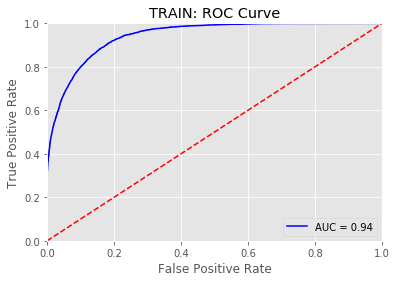

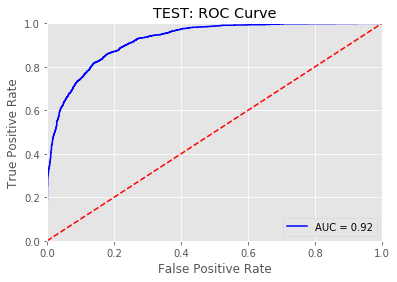

Accuracy  Precision  Recall    F1       AUC
Train      0.88       0.81    0.67  0.73  0.942355
Test       0.87       0.80    0.64  0.71  0.924199

In [8]:
## Metrics
clf_metrics(y_pred_train, y_proba_train, y_train, y_pred_test, y_proba_test, y_test)

The model's metrics seem to be pretty acceptable.

## Sensitive features 

There are several features in the dataset that could be considered as "sensitives" to include in the model, some of them more controversial than others. For instance, features like **Nationality**, **Race** and **Gender** are probably the most sensitive ones in determining an individual's income.

Moreover, even though features like **Age** and **Marital Status** may have good predictive power by covering up certain aspects such as years of work experience or education, they could also be considered sensitive. 

## Model Interpretation

### Global Importance

The techniques used to evaluate the global behavior of the model will be:

    1. Feature Importance (evaluated by the XGBoost model and by SHAP)
    2. Summary Plot (SHAP)
    3. Permutation Importance (ELI5)
    4. Partial Dependence Plot (evaluated by PDPBox and by SHAP)
    5. Global Surrogate Model (Decision Tree and Logistic Regression will be used) 


#### Mean Decrease Impurity
##### Feature Importance (XGBoost)

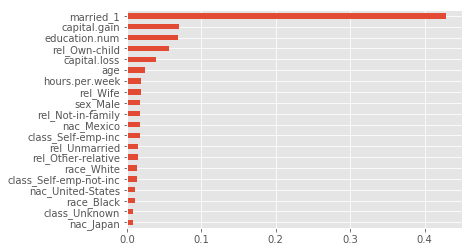

In [19]:
feat_importances = pd.Series(clf_xgb_df.feature_importances_, index = X_train.columns).sort_values(ascending=True)
feat_importances.tail(20).plot(kind='barh')

##### Feature Importance (SHAP)

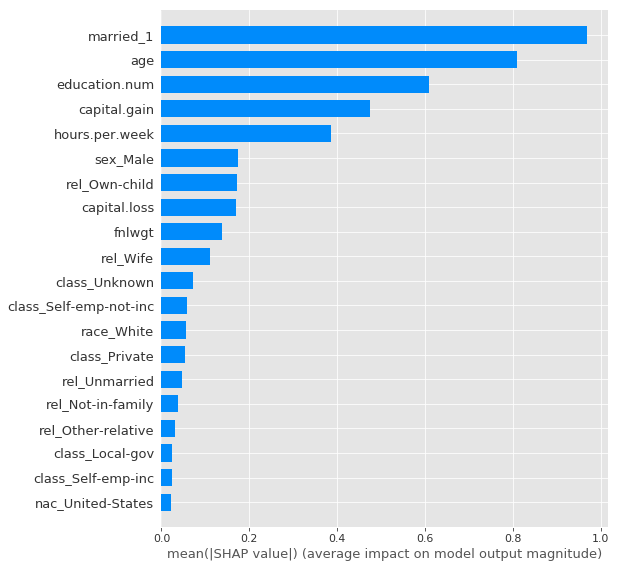

In [15]:
explainer = shap.TreeExplainer(clf_xgb_df)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type = 'bar')

The XGBoost feature importance was used to evaluate the relevance of the predictors in the model's outputs for the Train dataset and the SHAP one to evaluate it for Test dataset, in order to assess if the most important features were similar in both approaches.

It is observed that the most important variables of the model are maintained, although in different order of importance (*age* seems to take much more relevance in the SHAP approach)

#### Summary Plot (SHAP)

The SHAP Summary Plot is a very interesting plot to evaluate the features of the model, since it provides more information than the traditional *Feature Importance*:

- **Feature Importance**: variables are sorted in descending order of importance.
- **Impact on Prediction**: the position on the horizontal axis indicates whether the values of the dataset instances for each feature have more or less impact on the output of the model.
- **Original Value**: the color indicates, for each feature, whether it is a high or low value (in the range of each of the feature).
- **Correlation**: the correlation of a feature can be analyzed by evaluating its color (its range of values) and the impact on the horizontal axis. For example, it is observed that the *age* has a positive correlation, since the impact on the output increases as the value of the feature increases.

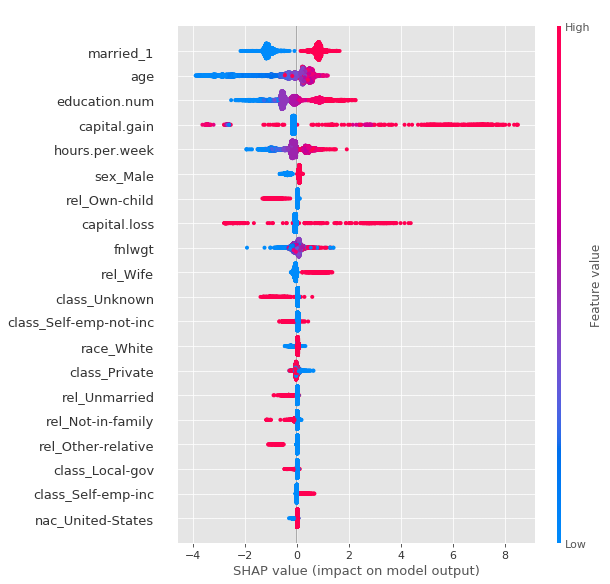

In [21]:
shap.summary_plot(shap_values, X_test)

#### Permutation Importance (ELI5)

Another way to assess the global importance of the predictors is to randomly permute the order of the instances for each feature in the dataset and predict with the trained model. If by doing this disturbance in the order, the evaluation metric does not change substantially, then the feature is not so relevant. If instead the evaluation metric is affected, then the feature is considered important in the model.

To evaluate the trained XGBoost model, the AUC of the ROC Curve will be used as a performance metric. Permutation Importance will be analyzed in both Train and Test

In [8]:
# Train
perm = PermutationImportance(clf_xgb_df, scoring = 'roc_auc', random_state=1984).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

In [9]:
# Test
perm = PermutationImportance(clf_xgb_df, scoring = 'roc_auc', random_state=1984).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Although the order of the most important features changes, it looks like that the most relevant ones remain the same. It is interesting to note that, unlike the XGBoost Feature Importance, the age variable in the Train set has a fairly strong effect (as showed by SHAP Feature Importance in the Test set). Furthermore, the 6 most important variables according to the Permutation Importance are kept in Train and Test (the difference in order may be due to the distribution of each sample).

The coherence between the different approaches to approximate the global importance generates more confidence in the interpretation of the model's output.

#### Partial Dependence Plot

The *Partial Dependence Plot (PDP)* indicates the marginal effect that a feature has individually on the predicted output. For this, the feature is modified, ceteris paribus, and the changes in the mean prediction are observed. The process carried out is as follows:

    1) Select feature
    2) Define grid of values
    3) For each value of the grid:
        a) Replace feature with grid value
        b) Average predictions
    4) Plot curve

The PDP can indicate if the relationship between the feature and the output is linear, monotonic or if it is more complex. It is relevant to note that **the observed relationship is with the prediction, but not with the target variable**. However, depending on the performance of the model, an intuition of the dependence of the target for the evaluated feature could be generated.

The **advantage** of PDP is that it is very ***easy to implement*** and it is ***quite intuitive***: the function in a particular feature represents the average prediction if all data points are forced to assume each particular value of the feature.

On the other hand, PDP has a number of **disadvantages**:

- ***Does not take into consideration the distribution of the feature***: it can be misleading, since it is possible to misinterpret regions with very little data (by allocating all the data points with these values, the value of the feature is being over-represented, which may lead to erroneous conclusions).
- ***Assumption of independence of the features***: it is one of the biggest drawbacks of PDP. It is assumed that the feature for which the partial dependence is computed is not correlated with the rest of the predictors.
- ***Heterogeneous effects may be hidden***: this is because only average marginal effects are computed. At the limit, the PDP could be a horizontal line, with the values evenly distributed above and below, concluding that the feature has no effect on the prediction. These effects can be identified by ploting *Individual Conditional Expectation (ICE)* curves.

To overcome some of the disadvantages of PDPs, *Individual Conditional Expectation (ICE)* and *Accumulated Local Effects (ALE)* plots can be used.


**Individual Conditional Expectation (ICE)**

ICE Plot is the PDP equivalent for individual data points. The plot displays a line for each instance of the dataset, indicating how the prediction of that instance varies as the value of the feature varies. A PDP is an average of all the lines in an ICE Plot. The ICE Plots allow to visualize the variance in the marginal effects, *being able to detect the heterogeneous effects*.


**Accumulated Local Effects (ALE) Plot**

PDPs present serious problems when a feature is highly correlated with other predictors, since synthetic instance predictions that are very unlikely to happen in reality are averaged (for example, it would be very unlikely that *age* were 16 and *education.num* were 10 simultaneously). This can generate a significant bias when estimating the effect of the feature. ALE Plots, in addition to being computed more quickly, are an unbiased solution to calculate the effect of a feature on model predictions, since they evaluate over its *conditional distribution*. That is, for a value x1 of the grid, they estimate using only the predictions of the instances that have a value similar to x1, thus avoiding the use of improbable instances in reality.

Furthermore, in order to estimate the effect of a feature on the prediction, instead of using the average (which mixes the effect of the feature with the effects of all the correlated predictors), they calculate the differences between predictions.

**Differences between ICE and ALE**

The ICE solves the problem of heterogeneous effects that PDPs can present, but not the bias due to correlated features. Instead, ALE solves bias problems, taking into consideration the conditional distribution of the feature and its correlation with the rest of the predictors.

We will analyze Partial Dependence Plots using PDPBox and SHAP

##### PDPBox  

The PDP for the 4 most relevant observed features will be analyzed:
    
    1. married_1
    2. capital.gain
    3. education.num
    4. age

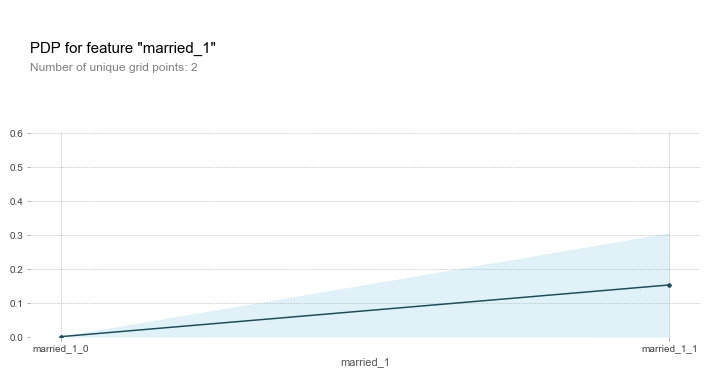

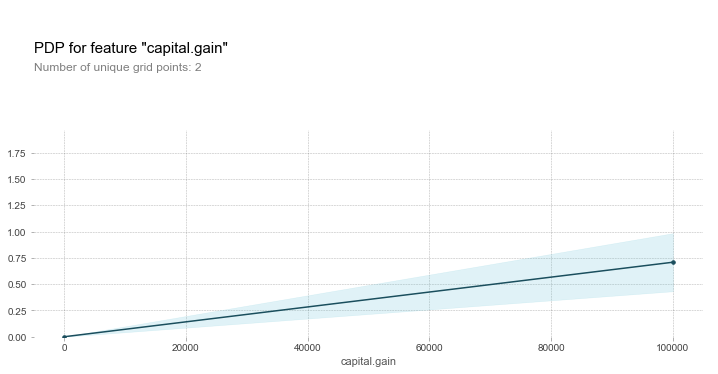

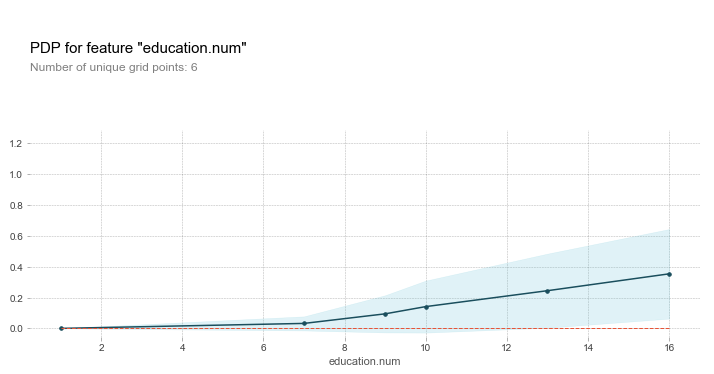

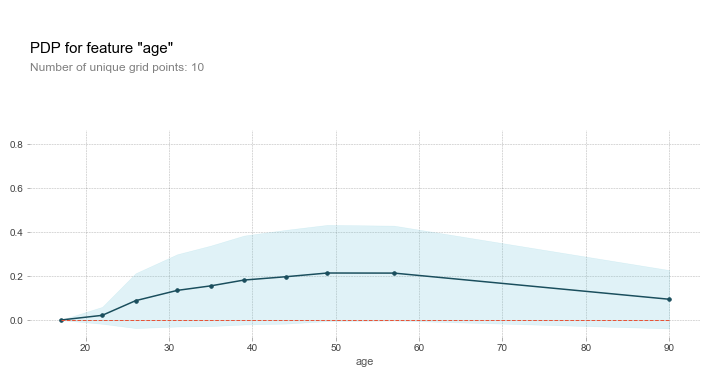

In [25]:
# Create the data that we will plot
pdp_married = pdp.pdp_isolate(model=clf_xgb_df, dataset=X_test, model_features=X_test.columns, feature='married_1')
pdp_capital = pdp.pdp_isolate(model=clf_xgb_df, dataset=X_test, model_features=X_test.columns, feature='capital.gain')
pdp_education = pdp.pdp_isolate(model=clf_xgb_df, dataset=X_test, model_features=X_test.columns, feature='education.num')
pdp_age = pdp.pdp_isolate(model=clf_xgb_df, dataset=X_test, model_features=X_test.columns, feature='age')

# Plot it
pdp.pdp_plot(pdp_married, 'married_1', figsize=(12, 6))
pdp.pdp_plot(pdp_capital, 'capital.gain', figsize=(12, 6))
pdp.pdp_plot(pdp_education, 'education.num',figsize=(12, 6))
pdp.pdp_plot(pdp_age, 'age', figsize=(12, 6))
plt.show()

##### SHAP Dependence Plot

The same PD plots will be generated using the SHAP approach. This library, in addition to indicating the marginal effect of the feature on the model's output, also indicates by color the relationship with the feature with which it most interacts.

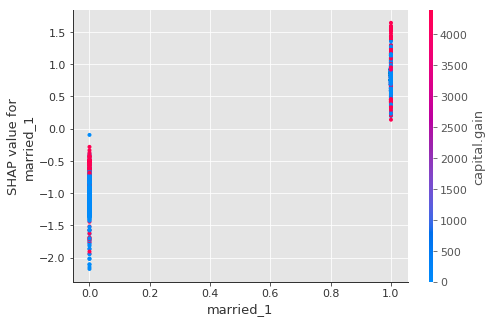

In [26]:
shap.dependence_plot('married_1', shap_values, X_test)

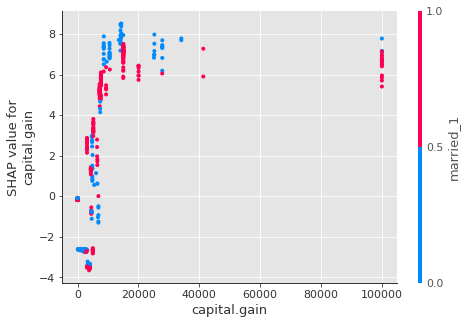

In [27]:
shap.dependence_plot('capital.gain', shap_values, X_test)

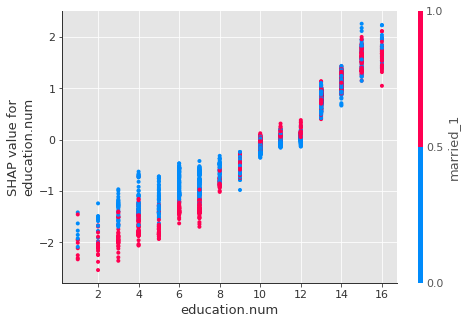

In [28]:
shap.dependence_plot('education.num', shap_values, X_test)

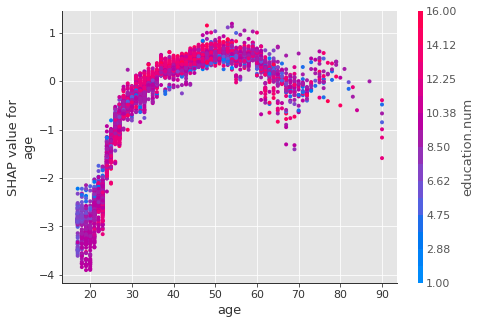

In [29]:
shap.dependence_plot('age', shap_values, X_test)

#### Global Surrogate Model

A global surrogate model is an interpretable model that is trained to approximate the predictions of a black box model. We can draw conclusions about the black box model by interpreting the surrogate model. In Christoph Molnar's words: "Solving machine learning interpretability by using more machine learning!"

##### Logistic Regression

In [31]:
log_clf = LogisticRegression().fit(X_train, y_train)

In [32]:
## Predictions
y_pred_train_log = log_clf.predict(X_train)
y_proba_train_log = log_clf.predict_proba(X_train)[:, 1]
y_pred_test_log = log_clf.predict(X_test)
y_proba_test_log = log_clf.predict_proba(X_test)[:, 1]

In [33]:
print('R-squared Train RL-XGB: ', r2_score(y_proba_train_log, y_proba_train))
print('R-squared Test RL-XGB: ', r2_score(y_proba_test_log, y_proba_test))

R-squared Train RL-XGB:  -1.563667507442175
R-squared Test RL-XGB:  -1.6896153203436244


The R-squared is negative for both Train and Test sets. This happens when the fit is worse than simply using the mean. Therefore, it is concluded that **Logistic Regression is not a good surrogate model**.

##### Decision Tree

In [34]:
tree_clf = tree.DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train, y_train)

In [35]:
## Predictions
y_pred_train_tr = tree_clf.predict(X_train)
y_proba_train_tr = tree_clf.predict_proba(X_train)[:, 1]
y_pred_test_tr = tree_clf.predict(X_test)
y_proba_test_tr = tree_clf.predict_proba(X_test)[:, 1]

R-squared Train DT-XGB:  0.7199434946682943
R-squared Test DT-XGB:  0.7145484050221372


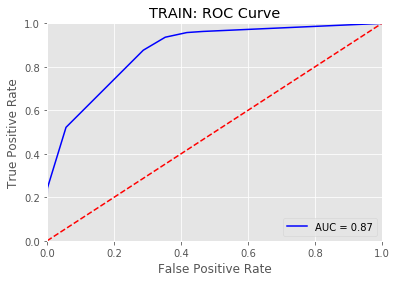

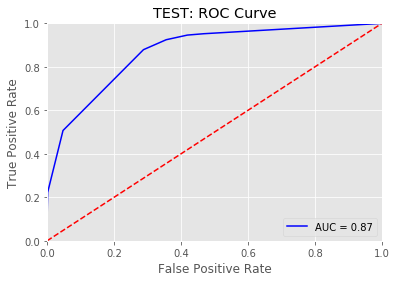

Accuracy  Precision  Recall    F1       AUC
Train      0.84       0.74    0.52  0.61  0.874041
Test       0.84       0.78    0.51  0.61  0.869740

In [38]:
## r2
print('R-squared Train DT-XGB: ', r2_score(y_proba_train_tr, y_proba_train))
print('R-squared Test DT-XGB: ', r2_score(y_proba_test_tr, y_proba_test))

## Metricas
clf_metrics(y_pred_train_tr, y_proba_train_tr, y_train, y_pred_test_tr, y_proba_test_tr, y_test)

**The variance in the XGBoost model predictions is fairly well approximated by the Decision Tree, so it can serve as a surrogate model for interpreting the main model**. In fact, the performance metrics are also quite close to the original model.

It is important to note that while the variance of the XGBoost predictions is well explained by the Decision Tree, ***it is not guaranteed*** that the latter uses the features in the same way as the former. It could happen that the Tree approximates the XGBoost correctly in some areas of the input space, but behaves drastically differently in other regions.

The resulting tree will be analyzed in order to assess whether the features used correspond to the most important features that have been detected so far.

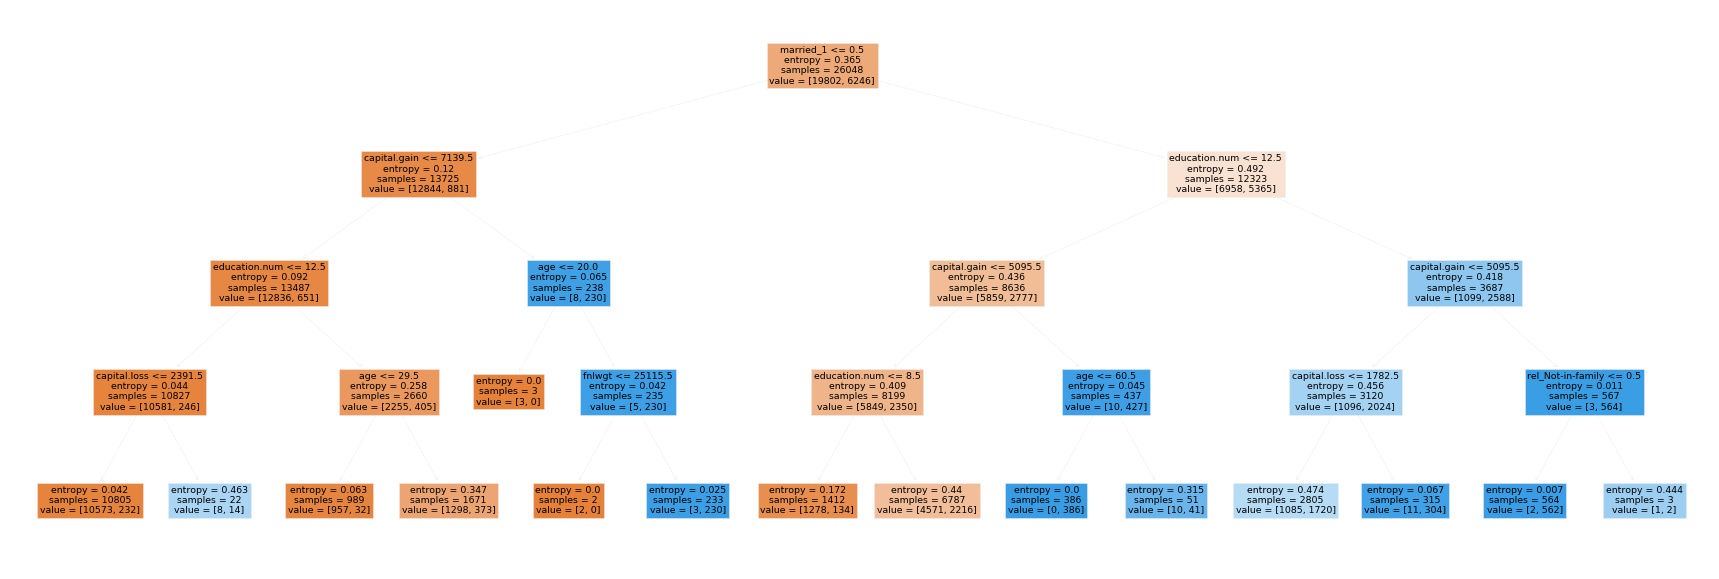

In [39]:
fig, ax = plt.subplots(figsize=(30, 10)) 
tree.plot_tree(tree_clf, feature_names= X_train.columns.to_list(), ax=ax, filled=True)
plt.show()

The 5 features that the tree used to estimate the *Income*, in order of importance, are:

    1. married_1
    2. education.num
    3. capital.gain
    4. capital.loss
    5. age

These features correspond to the most important ones that have been detected by other methodologies.

### Local Importance

Local surrogate models are interpretable models that are used to explain individual predictions of black box machine learning models. 

#### Local Interpretability (LIME)

Local Interpretable Model-agnostic Explanations (LIME) analyzes what happens in model predictions when variations are made to the input data. It generates a new dataset with permuted samples and their corresponding predictions from the original model. On this synthetic set LIME trains interpretable models (Logistic Regression, Decision Tree, LASSO, etc.), which are then weighted by the proximity of the sampled instances to the instance of interest.

**The explanation for instance X will be that of the surrogate model that minimizes the loss function (performance measure -i.e. MSE- between the prediction of the surrogate model and the prediction of the original model), keeping the complexity of the model low.**

In [10]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='classification',
                                                   feature_names=X_train.columns.tolist(),
                                                   discretize_continuous=False, random_state=1984)

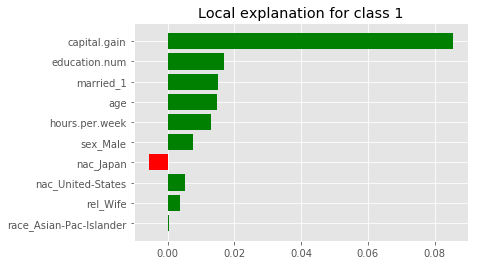

In [11]:
# Generate an explanation
i = 546
exp = explainer.explain_instance(X_test.values[i], clf_xgb_array.predict_proba)

%matplotlib inline
fig = exp.as_pyplot_figure();

In [18]:
sp_obj = submodular_pick.SubmodularPick(explainer, X_test.values, clf_xgb_array.predict_proba, 
                                        sample_size=3, num_exps_desired=3)

In [19]:
[exp.show_in_notebook() for exp in sp_obj.sp_explanations]

[None, None, None]

It is observed that the most influential feature in all individual interpretations to separate the classes is *capital.gain*. Following this, depending on the instance, the predictors of greatest relevance are *married*, *education.num*, *age* and *sex*. These features are the same that were identified in the algorithms of global importance.

#### Local Interpretability (SHAP)

SHAP (SHapley Additive exPlanations) is a method to explain individual predictions based on the calculation of Shapley Values, a method from coalitional game theory. It seeks to answer the question **"How much has each feature value contributed to the prediction, relative to the average prediction?"**. To do this, the Shapley Values assign "payments" to "players" depending on their contribution to the "total payment". Players cooperate in a coalition and receive certain rewards for such cooperation.

In the machine learning context, the "game" is the prediction task for an instance of the dataset. The "total payment" is the prediction for that instance, minus the average prediction for the entire dataset. The "players" are the values of the features for the instance, which cooperate in a coalition to receive the "payment" (the prediction). The Shapley Value is the average marginal contribution of a feature value for all possible coalitions. It indicates how the "total payout" (prediction) is distributed among all "players" (the feature values).

One innovation that SHAP brings to the table is that the Shapley value explanation is represented as an additive feature attribution method, namely a linear model. In this way, ***SHAP connects the benefits of LIME with the Shapley Values***.

**The great advantage of SHAP** is its contribution to the field of interpretable Machine Learning. This is so since here ***the global interpretations are consistent with the individual explanations, since the Shapley Values are the "atomic unit" of the global interpretations (which have a solid theoretical foundation in Game Theory)***. If, for example, LIME were used for local explanations and PDP or Permutation Importance for global interpretations, there is no common theoretical foundation between the methods.

In [20]:
explainer = shap.TreeExplainer(clf_xgb_df, model_output='probability', feature_dependence='independent', data = X_test)

**Force Plot**

In [21]:
row_to_show = 150
data_for_prediction = X_test.iloc[row_to_show, :]

shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

The force plot indicates, for each feature, the impact it had on the prediction. There are two relevant values to notice: the **output value** (model prediction for the instance) and the **base value** (average prediction for the entire dataset). A bigger bar means a higher impact and the color indicates if the feature moved the prediction from the base value towards 1 (*red*) or 0 (*blue*).

**Decision Plot**

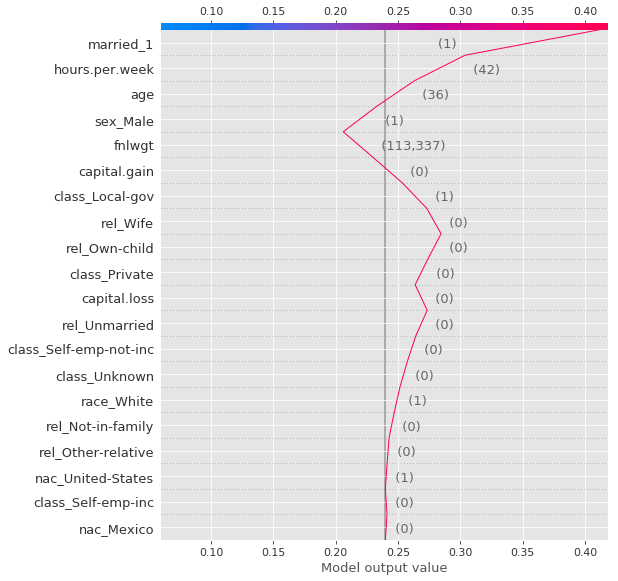

In [28]:
shap.decision_plot(explainer.expected_value, shap_values, data_for_prediction)

## Model Fairness

Like most interpretation algorithms, the basic idea behind FairML is to measure how the model's predictions vary with perturbations in the inputs. If a small change in a feature dramatically modifies the output, then the model is sensitive to that feature.

However, if the features are correlated, the indirect effects between them might still not be accounted for in the interpretation model. **FairML addresses this multicollinearity problem using orthogonal projection**.

|Orthogonal Projection||
|:-------|:------------|
|An orthogonal projection is a type of vector projection that maps a vector onto the orthogonal (perpendicular) direction of another vector. If a vector *a* is projected onto a vector *b* (in Euclidean space), the component of *a* that lies in the direction of *b* is obtained. This concept is very important in FairML since it allows to completely remove the linear dependence between features. If 2 vectors are orthogonal to each other, then there is no linear combination of one vector that can produce the other. The component of *a* orthogonal to *b*, can be calculated as *a2* = *a* - *a1*|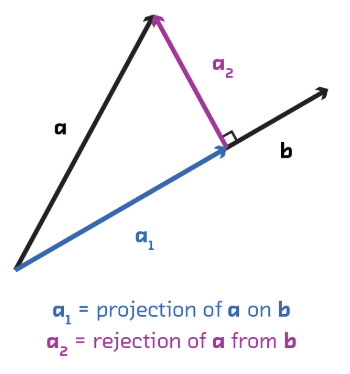|

|FairML Process||
|:------------|:------------|
|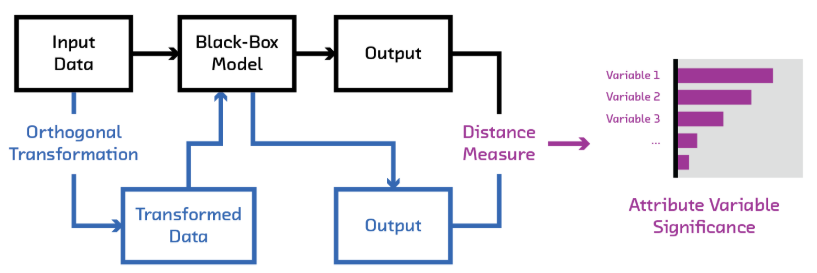|If *F* is a model trained with 2 features *x* e *y*, to calculate the dependence of *F* on *x*, firstly *y* is made orthogonal to *x* to remove all dependencies between the two. Secondly, the variation in the model output is analyzed using the orthogonal component of *y* and making perturbations in *x*. The change in output between the perturbed input and the original input indicates the dependence of the model on *x*. The dependence of *F* on *y* can be estimated in the same way.|

**Orthogonal Projection guarantees that there will be no hidden collinearity effects**. It is important to note that this is a linear transformation, so it does not account for non-linear dependencies between features. To solve this, FairML uses basis expansion and a greedy search over such expansions.

In [51]:
# Model audit
importances, _ = audit_model(clf_xgb_array.predict, X_train, distance_metric="mse")

In [52]:
importances_dict={i:np.mean(np.array(f).astype(np.float)) for i,f in importances.items()}
pd.DataFrame(importances_dict, index=['Importance']).transpose().sort_values(by='Importance', ascending=False)

Importance
hours.per.week            0.177403
education.num             0.176943
fnlwgt                    0.171990
married_1                 0.166615
race_White                0.163007
...                            ...
class_State-gov          -0.009790
class_Self-emp-not-inc   -0.013168
class_Local-gov          -0.016700
class_Private            -0.107494
age                      -0.176827

[66 rows x 1 columns]

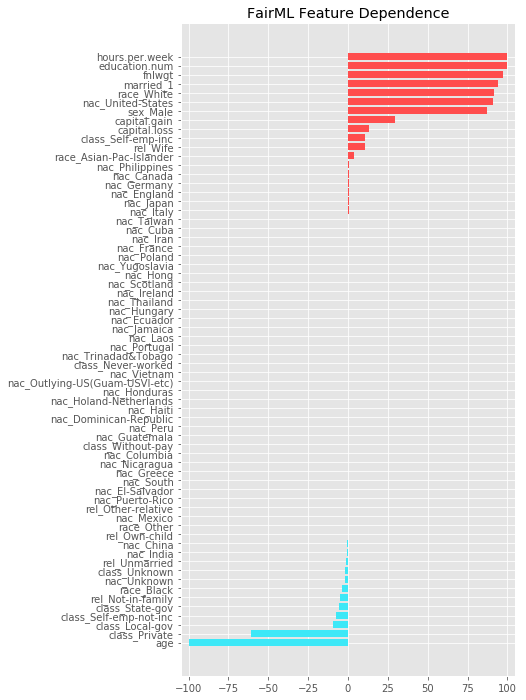

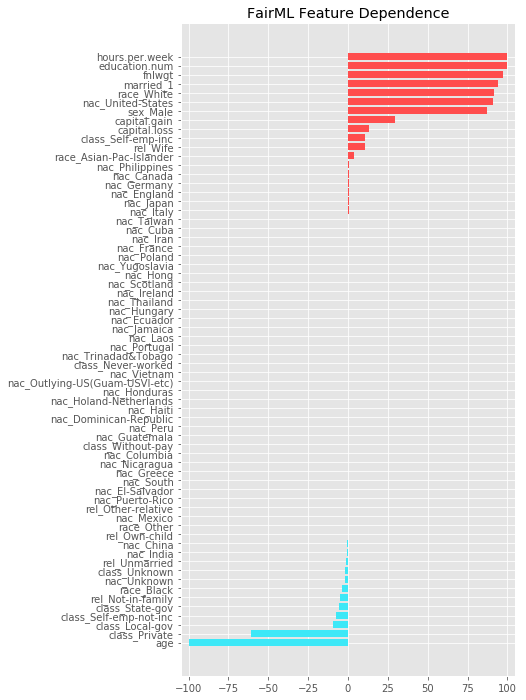

In [53]:
plot_dependencies(
    importances.median(),
    reverse_values=False,
    title="FairML Feature Dependence",
    fig_size=(6,12)
)

FairML allows to plot the dependence of the output on each feature (excluding the effect of the correlation with the other predictors). Red bars indicate that the feature contributes to an output 1 (Income > 50K), while light blue bars indicate that it contributes to an output 0 (Income <= 50K).

It is observed that this algorithm, by removing the dependence between features through orthogonal projection, identifies that the model has a high dependence on sensitive features such as *race_White*, *nac_United-States* and *sex_Male*. In other words, according to the trained model, a white man born in the United States will have a high probability of having an income greater than USD 50,000, which constitutes a very strong bias.

**It is very important to notice the relevance of the orthogonal projection in the algorithm**, since features such as *race_White* and *nac_United-States* did not appear to be so relevant in the other interpretation algorithms. This is probably because the effects of these are hidden in other features. By removing multicollinearity and evaluating the individual dependence on each feature, it is possible to identify the intrinsic effects of each one.